
# <center><span style='background:blue'>Segmentez des clients d'un site e-commerce (partie 3)</span></center>
=========================================================================================================================

### Table of Contents <a class="anchor" id="sommaire"></a>
* [Première méthode](#01)
    * [Simulation de l'évolution des clusters du 31 Déc 2017 au 14 Oct 2018](#1)
    * [Simulation de l'évolution des clusters par la période de maintenance simulée](#11)

* [Deuxième méthode](#02)
    * [Méthode 2 : Simulation de l'évolution des clusters du 17 Oct 2018 au 3 Jan 2018](#2)
    * [Simulation de l'évolution des clusters par la période de maintenance simulée](#22)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%store -r

In [2]:
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,montant_command,n_produits,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87,1,4.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48,1,5.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73,1,5.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30,1,5.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25,1,5.0


In [3]:
data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp)
t_init = pd.to_datetime('31/12/2017', infer_datetime_format=True)
t_final = data.order_purchase_timestamp.max()
dt = '7D'

# l'ensemble des périodes à étudier
dates = pd.date_range(t_init,
                  t_final,
                  freq=dt
                 )

NOW = data.order_purchase_timestamp.max() + timedelta(1)

def transformer(df, date):
    df.order_purchase_timestamp = pd.to_datetime(df.order_purchase_timestamp)
    df_t = df.loc[df.order_purchase_timestamp <= date].copy()
    df_t['DaysSinceOrder'] = df_t['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)
    aggs = {'DaysSinceOrder' : lambda x : min(x),
       'order_purchase_timestamp' : 'count',
       'montant_command' : sum}

    rfm = df_t.groupby('customer_unique_id').agg(aggs)
    
    rfm.rename(columns={'DaysSinceOrder':'recency', 
                        'order_purchase_timestamp':'frequency', 
                        'montant_command':'monetary'
                       },
           inplace=True)
    epsilon = 10e-1
    rfm_log = rfm.apply(lambda x : np.log(x+epsilon))
    
    return rfm_log

# Première méthode<a class="anchor" id="01"></a>

## Simulation de l'évolution des clusters du 31 Déc 2017 au 14 Oct 2018<a class="anchor" id="1"></a>

In [12]:
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.pipeline import make_pipeline

data_init = transformer(data, t_init)
pipeline_init = make_pipeline(StandardScaler(), KMeans(n_clusters=4, n_init=2, init="k-means++"))
pipeline_init.fit(data_init)

ari_scores = []
accuracy_scores = []
for t in dates:
    data_t = transformer(data, t)
    pipeline_t = make_pipeline(StandardScaler(), KMeans(n_clusters=4, n_init=2, init="k-means++"))
    pipeline_t.fit(data_t)
    ari_scores += [adjusted_rand_score(pipeline_init.predict(data_t), pipeline_t[1].labels_)]
    accuracy_scores += [accuracy_score(pipeline_init.predict(data_t), pipeline_t[1].labels_)]
    
df_scores1 = pd.DataFrame({'DATE' : [date.date() for date in dates],
                          'PERIOD' : [str(x) for x in range(len(dates))],
                          'ARI' : ari_scores
                         })
df_scores1.head()

CPU times: total: 59.1 s
Wall time: 49.2 s


,DATE,PERIOD,ARI
0,2018-08-09,0,0.981810
1,2018-08-16,1,0.906939
2,2018-08-23,2,0.879036
3,2018-08-30,3,0.843965
4,2018-09-06,4,0.858117


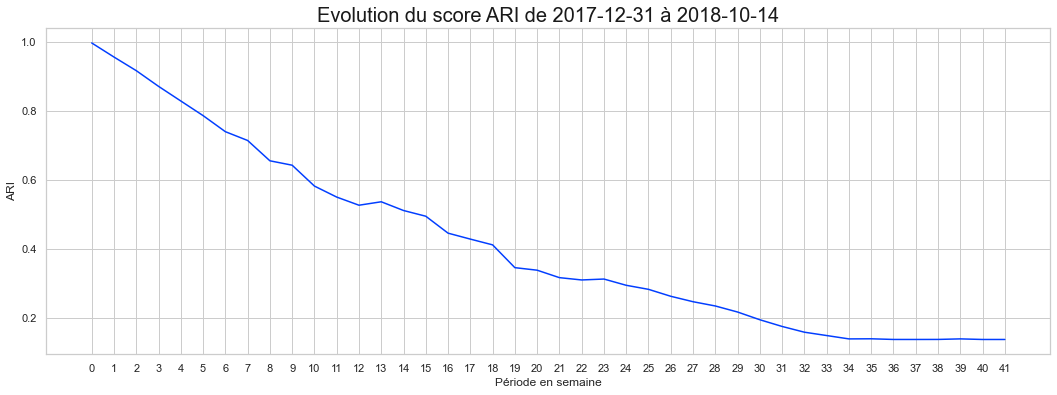

In [5]:
plt.figure(figsize=(18,6))
sns.set_theme(palette='bright', style='whitegrid')
sns.lineplot(data = df_scores1, x = 'PERIOD', y = 'ARI')
plt.xlabel('Période en semaine')
plt.title(f'Evolution du score ARI de {df_scores1.DATE[0]} à {df_scores1.DATE[df_scores1.shape[0]-1]}', c='k', fontsize=20)
plt.show()

La période de maintenance est de 4 semaines

<a href="#sommaire" rev="footnote">&#8617;</a>

## Simulation de l'évolution des clusters par la période de maintenance simulée<a class="anchor" id="11"></a>

In [6]:
from datetime import timedelta

t_final = data.order_purchase_timestamp.max()
t_init = t_final - timedelta(60)

# l'ensemble des périodes à étudier
dates = pd.date_range(t_init,
                  t_final,
                  freq=dt
                 )

data_init = transformer(data, t_init)
pipeline_init = make_pipeline(StandardScaler(), KMeans(n_clusters=4, n_init=2, init="k-means++"))
pipeline_init.fit(data_init)

ari_scores = []
accuracy_scores = []
for t in dates:
    data_t = transformer(data, t)
    pipeline_t = make_pipeline(StandardScaler(), KMeans(n_clusters=4, n_init=2, init="k-means++"))
    pipeline_t.fit(data_t)
    ari_scores += [adjusted_rand_score(pipeline_init.predict(data_t), pipeline_t[1].labels_)]
    accuracy_scores += [accuracy_score(pipeline_init.predict(data_t), pipeline_t[1].labels_)]
    
df_scores2 = pd.DataFrame({'DATE' : [date.date() for date in dates],
                          'PERIOD' : [str(x) for x in range(len(dates))],
                          'ARI' : ari_scores
                         })
df_scores2.head()

,DATE,PERIOD,ARI
0,2018-08-18,0,0.988855
1,2018-08-25,1,0.933709
2,2018-09-01,2,0.923764
3,2018-09-08,3,0.946852
4,2018-09-15,4,0.945843


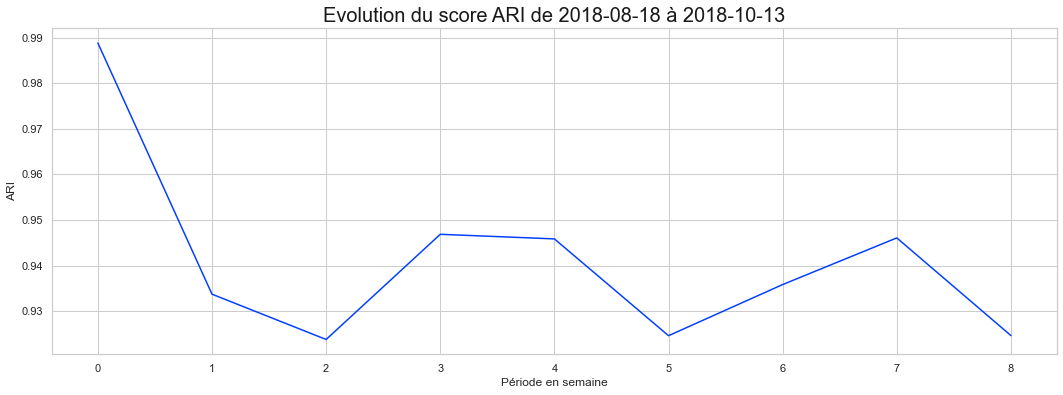

In [7]:
plt.figure(figsize=(18,6))
sns.set_theme(palette='bright', style='whitegrid')
sns.lineplot(data = df_scores2, x = 'PERIOD', y = 'ARI')
plt.xlabel('Période en semaine')
plt.title(f'Evolution du score ARI de {df_scores2.DATE[0]} à {df_scores2.DATE[df_scores2.shape[0]-1]}', c='k', fontsize=20)
plt.show()

<a href="#sommaire" rev="footnote">&#8617;</a>

# Deuxième méthode<a class="anchor" id="02"></a>

## Simulation de l'évolution des clusters du 17 Oct 2018 au 3 Jan 2018<a class="anchor" id="2"></a>

In [8]:
t_final = pd.to_datetime('31/12/2017', infer_datetime_format=True)
t_init = data.order_purchase_timestamp.max()
dt = '-7D'

# l'ensemble des périodes à étudier
dates = pd.date_range(t_init,
                  t_final,
                  freq=dt
                 )
# entraînement initial
data_init = transformer(data, t_init)
pipeline_init = make_pipeline(StandardScaler(), KMeans(n_clusters=4, n_init=2, init="k-means++"))
pipeline_init.fit(data_init)

# entraînement des modèles sur des différentes périodes et calcul leurs ari avec le modèle initiale
ari_scores = []
accuracy_scores = []
for t in dates:
    data_t = transformer(data, t)
    pipeline_t = make_pipeline(StandardScaler(), KMeans(n_clusters=4, n_init=2, init="k-means++"))
    pipeline_t.fit(data_t)
    ari_scores += [adjusted_rand_score(pipeline_init.predict(data_t), pipeline_t[1].labels_)]
    
df_scores3 = pd.DataFrame({'DATE' : [date.date() for date in dates],
                          'PERIOD' : [str(x) for x in range(len(dates))],
                          'ARI' : ari_scores
                         })
df_scores3.head()

,DATE,PERIOD,ARI
0,2018-10-17,0,0.985957
1,2018-10-10,1,0.959058
2,2018-10-03,2,0.960882
3,2018-09-26,3,0.964039
4,2018-09-19,4,0.998074


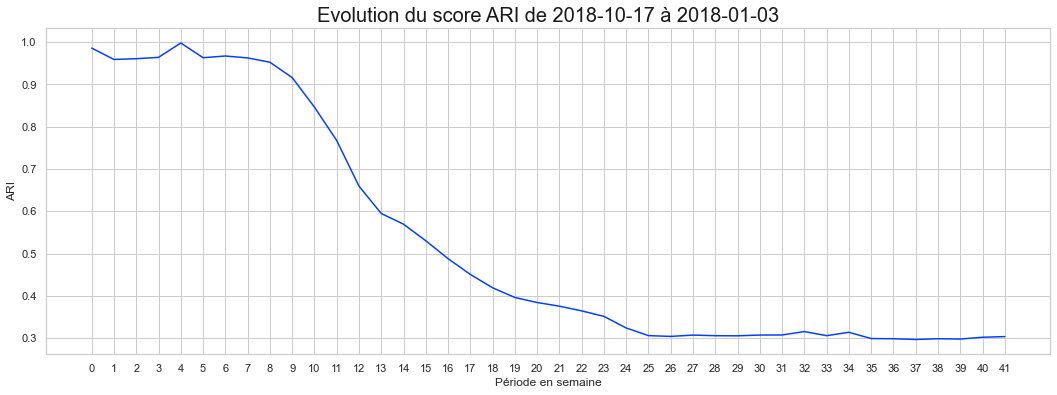

In [9]:
fig = plt.figure(figsize=(18,6))
sns.set_theme(palette='bright', style='whitegrid')
sns.lineplot(data = df_scores3, x = 'PERIOD', y = 'ARI')
plt.xlabel('Période en semaine')
plt.title(f'Evolution du score ARI de {df_scores3.DATE[0]} à {df_scores3.DATE[df_scores3.shape[0]-1]}', c='k', fontsize=20)
plt.show()

fig.savefig('stabilite1.png')

**La période de maintenance est de 70 jours**

<a href="#sommaire" rev="footnote">&#8617;</a>

## Simulation de l'évolution des clusters par la période de maintenance simulée<a class="anchor" id="22"></a>

In [10]:
t_final = NOW
t_init = t_final - timedelta(70)
dt = '7D'

# l'ensemble des périodes à étudier
dates = pd.date_range(t_init,
                  t_final,
                  freq=dt
                 )

# fit du modèle initial 
data_init = transformer(data, t_init)
pipeline_init = make_pipeline(StandardScaler(), KMeans(n_clusters=4, n_init=2, init="k-means++"))
pipeline_init.fit(data_init)

# itération sur une période de 70 jours avant la date courante (de (NOW - 70j) à NOW)
ari_scores = []
accuracy_scores = []
for t in dates:
    data_t = transformer(data, t)
    pipeline_t = make_pipeline(StandardScaler(), KMeans(n_clusters=4, n_init=2, init="k-means++"))
    pipeline_t.fit(data_t)
    ari_scores += [adjusted_rand_score(pipeline_init.predict(data_t), pipeline_t[1].labels_)]
    
df_scores4 = pd.DataFrame({'DATE' : [date.date() for date in dates],
                          'PERIOD' : [str(x) for x in range(len(dates))],
                          'ARI' : ari_scores
                         })
df_scores4.head()

,DATE,PERIOD,ARI
0,2018-08-09,0,0.957719
1,2018-08-16,1,0.915207
2,2018-08-23,2,0.878984
3,2018-08-30,3,0.865549
4,2018-09-06,4,0.848634


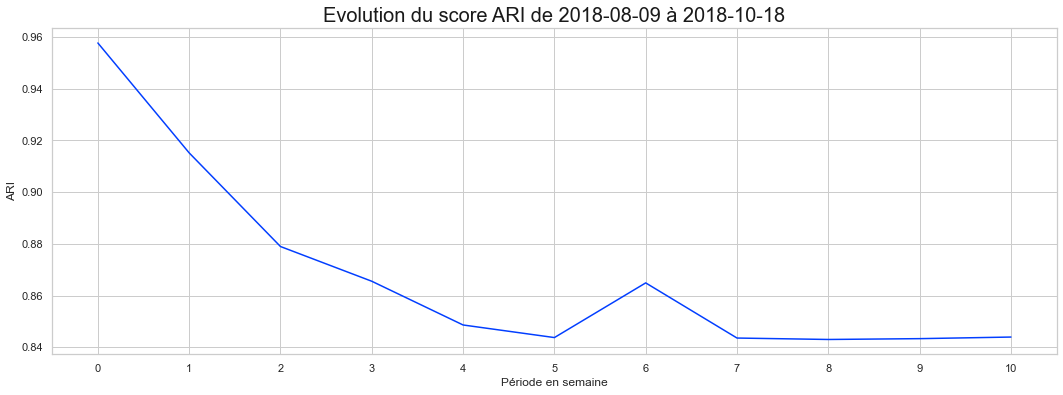

In [11]:
fig = plt.figure(figsize=(18,6))
sns.set_theme(palette='bright', style='whitegrid')
sns.lineplot(data = df_scores4, x = 'PERIOD', y = 'ARI')
plt.xlabel('Période en semaine')
plt.title(f'Evolution du score ARI de {df_scores4.DATE[0]} à {df_scores4.DATE[df_scores4.shape[0]-1]}', c='k', fontsize=20)
plt.show()

fig.savefig('stabilité2.png')

<a href="#sommaire" rev="footnote">&#8617;</a>